<a href="https://colab.research.google.com/github/ariG23498/NeuralStyleTransfer/blob/master/Amalgamation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from tqdm import tqdm

In [2]:
print('tf Version: {}'.format(tf.__version__))
print('Executing eagerly: {}'.format(tf.executing_eagerly()))

tf Version: 2.3.0
Executing eagerly: True


# Dataset

In [4]:
# Gather dataset
anchor_image_path = tf.keras.utils.get_file(
    "paris.jpg", "https://i.imgur.com/F28w3Ac.jpg"
    )
style_image_path = tf.keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
    )

In [44]:
def prepare_image(image_path):
  image_pixels = plt.imread(image_path)
  image_pixels = cv2.resize(image_pixels, (224, 224))
  image_pixels = image_pixels/255.
  image = np.array(image_pixels, dtype=np.float32)
  print(image.shape)
  return image

In [45]:
anchor = prepare_image(anchor_image_path)
style = prepare_image(style_image_path)

(224, 224, 3)
(224, 224, 3)


In [46]:
print(anchor.dtype)
print(style.dtype)

float32
float32


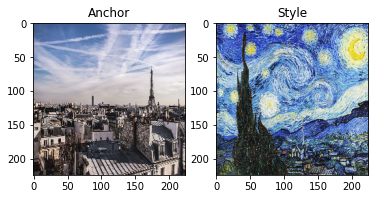

In [47]:
plt.subplot(1,2,1)
plt.imshow(anchor)
plt.title('Anchor')
plt.subplot(1,2,2)
plt.imshow(style)
plt.title('Style')
plt.show()

# Pretrained VGG16

In [23]:
model = tf.keras.applications.VGG16()
model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [24]:
for layer in model.layers:
  layer.trainable = False

In [25]:
for layer in model.layers:
  print('{} trainable: {}'.format(layer.name, layer.trainable))

input_1 trainable: False
block1_conv1 trainable: False
block1_conv2 trainable: False
block1_pool trainable: False
block2_conv1 trainable: False
block2_conv2 trainable: False
block2_pool trainable: False
block3_conv1 trainable: False
block3_conv2 trainable: False
block3_conv3 trainable: False
block3_pool trainable: False
block4_conv1 trainable: False
block4_conv2 trainable: False
block4_conv3 trainable: False
block4_pool trainable: False
block5_conv1 trainable: False
block5_conv2 trainable: False
block5_conv3 trainable: False
block5_pool trainable: False
flatten trainable: False
fc1 trainable: False
fc2 trainable: False
predictions trainable: False


# Layers of the model

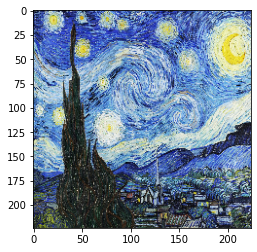

In [49]:
# the layers that I want to tap
layers = [
          'block5_pool',
          'block4_pool',
          'block3_pool',
          'block2_pool',
          'block1_pool'
]
# The input of choice
X = tf.constant(tf.expand_dims(style,0))
plt.imshow(X[0])
plt.show()

In [50]:
# the models created
models = list()
# images created
white_images = list()
# outputs created
output_images = list()
# loss created
losses = list()

for layer in layers:
  m = tf.keras.Model(
      inputs=model.input,
      outputs=model.get_layer(layer).output
      )
  models.append(m)

  white_images.append(
      tf.Variable(tf.expand_dims(anchor,0))
      )
  
  losses.append(
      list()
      )
  
  output_images.append(
      m(X)
  )

In [51]:
def train_step(anchor, white, slice_model, loss_history):
  with tf.GradientTape() as tape:
    output_white_image = slice_model(white)
    loss = loss_fun(anchor, output_white_image)

  loss_history.append(loss.numpy().mean())
  grads = tape.gradient(loss, [white])
  optimizer.apply_gradients(
      zip(grads, [white])
      )

# Iterate and watch

In [52]:
optimizer = tf.keras.optimizers.Adam()
loss_fun = tf.keras.losses.MSE
for idx,layer in enumerate(layers):
  print("For {} layer. Name {}".format(idx, layer))
  for i in tqdm(range(100)):
    train_step(output_images[idx], white_images[idx], models[idx], losses[idx])

  0%|          | 0/100 [00:00<?, ?it/s]

For 0 layer. Name block5_pool


  0%|          | 0/100 [00:00<?, ?it/s]

For 1 layer. Name block4_pool


  0%|          | 0/100 [00:00<?, ?it/s]

For 2 layer. Name block3_pool


  0%|          | 0/100 [00:00<?, ?it/s]

For 3 layer. Name block2_pool


  0%|          | 0/100 [00:00<?, ?it/s]

For 4 layer. Name block1_pool


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


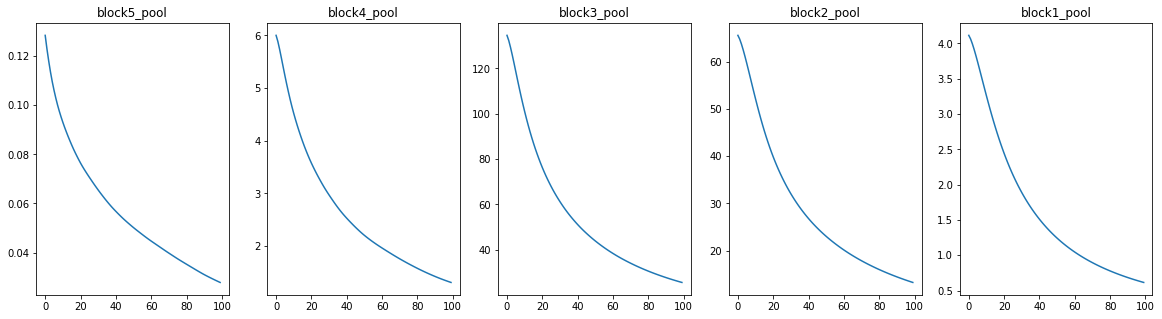

In [53]:
plt.figure(figsize=(20,5))
for idx,loss in enumerate(losses):
  plt.subplot(1,5,idx+1)
  plt.plot(loss) 
  plt.title(layers[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


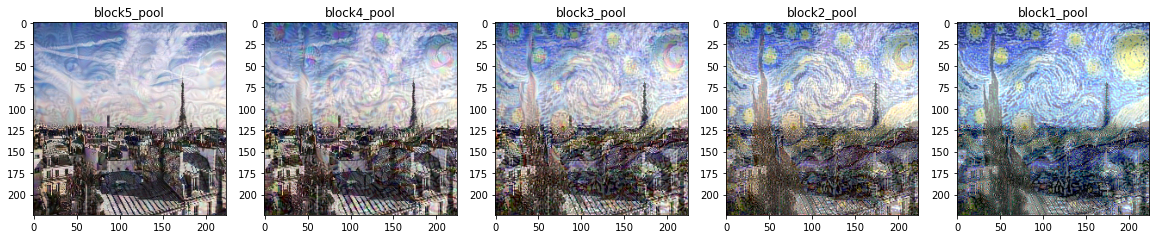

In [54]:
plt.figure(figsize=(20,5))
for idx,image in enumerate(white_images):
  plt.subplot(1,5,idx+1)
  plt.imshow(image[0])
  plt.title(layers[idx])